<a href="https://colab.research.google.com/github/AbhinitRai/Anomaly-Detection-Model/blob/main/Anomaly_Detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [135]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.decomposition import PCA
import seaborn as sns
sns.set(color_codes=True)
import matplotlib as mpl
import matplotlib.pyplot as plt 
%matplotlib inline
from numpy.random import seed
%tensorflow_version 1.x
import tensorflow
##directly use set_random_seed as tensorflow.random.set_seed
print(tensorflow.__version__)
from tensorflow import keras
from keras.layers import Input,Dropout
from keras.layers.core import Dense
from keras.models import Model,Sequential,load_model
from keras import regularizers
from keras.models import  model_from_json


1.15.2


# Importing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
temp=pd.read_csv('/content/drive/MyDrive/intership-data-1.csv')
temp.head()

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
0,1/1/2017 0:00,867.63,910.42,-189.54,-186.04,852.13,-145.9
1,1/1/2017 0:05,879.23,918.14,-184.33,-182.1,862.53,-149.76
2,1/1/2017 0:10,875.67,924.18,-181.26,-166.47,866.06,-145.01
3,1/1/2017 0:15,875.28,923.15,-179.15,-174.83,865.85,-142.82
4,1/1/2017 0:20,891.66,934.26,-178.32,-173.72,876.06,-143.39


In [4]:
row=len(temp['Cyclone_Inlet_Draft'])
row

377719

##Removing Null Values

In [5]:
temp.isnull().values.any()

False

In [6]:
temp.describe()

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,377719,377719,377719,377719,377719,377719,377719
unique,377719,39736,39662,27669,26487,48044,24010
top,3/30/2020 21:55,Not Connect,0,Not Connect,Not Connect,28.88,Not Connect
freq,1,723,14226,723,723,2036,723


#Checking Manually for Anomalies in the Data

In [7]:
sa=set()
def set_add(string):
   for strin in string:
    if str.isalpha(strin[0]):
      sa.add(strin)


In [8]:
temp.apply(lambda x:set_add(x),axis=1)
print(sa)

{'I/O Timeout', 'Configure', 'Comm Fail', 'Scan Timeout', 'Not Connect', 'Unit Down'}


Manually out of the 5 string values 'I/O timeout', 'Not Connect', 'Scan Timeout' and 'Comm Fail' can be eliminated because they can arise due to network issue in the server collecting data.Since,they do not clearly give us the idea of abnormality we can eliminate them.'Unit Down' arise always due to failure in machinery and they can be considerd abnormality and 'Configure' can also be somewhat considered faulty so we will include it too.



In [9]:
result=pd.DataFrame(columns=['Abnormality_Time'])                                             ###Stroing the abnormalty occurence timestamp values to show as a result
for i,row in temp.iterrows():
  if row['Cyclone_Inlet_Gas_Temp'] in sa or  row['Cyclone_Material_Temp']=='Unit Down' or row['Cyclone_Outlet_Gas_draft']=='Unit Down' or row['Cyclone_cone_draft']=='Unit Down' or row['Cyclone_Gas_Outlet_Temp']=='Unit Down' or row['Cyclone_Inlet_Draft']=='Unit Down':
      if row['Cyclone_Inlet_Gas_Temp']=='Configure' or  row['Cyclone_Material_Temp']=='Unit Down' or row['Cyclone_Outlet_Gas_draft']=='Unit Down' or row['Cyclone_cone_draft']=='Unit Down' or row['Cyclone_Gas_Outlet_Temp']=='Unit Down' or row['Cyclone_Inlet_Draft']=='Unit Down':
        result = result.append({'Abnormality_Time' : row['time']},  
                ignore_index = True)
      temp.drop(i,inplace=True)

In [10]:
result.describe()

,Abnormality_Time
count,383
unique,383
top,10/12/2017 1:00
freq,1


In [11]:
temp=temp.astype({'Cyclone_Inlet_Gas_Temp':'float64','Cyclone_Material_Temp':'float64','Cyclone_Outlet_Gas_draft':'float64','Cyclone_cone_draft':'float64','Cyclone_Gas_Outlet_Temp':'float64','Cyclone_Inlet_Draft':'float64'})


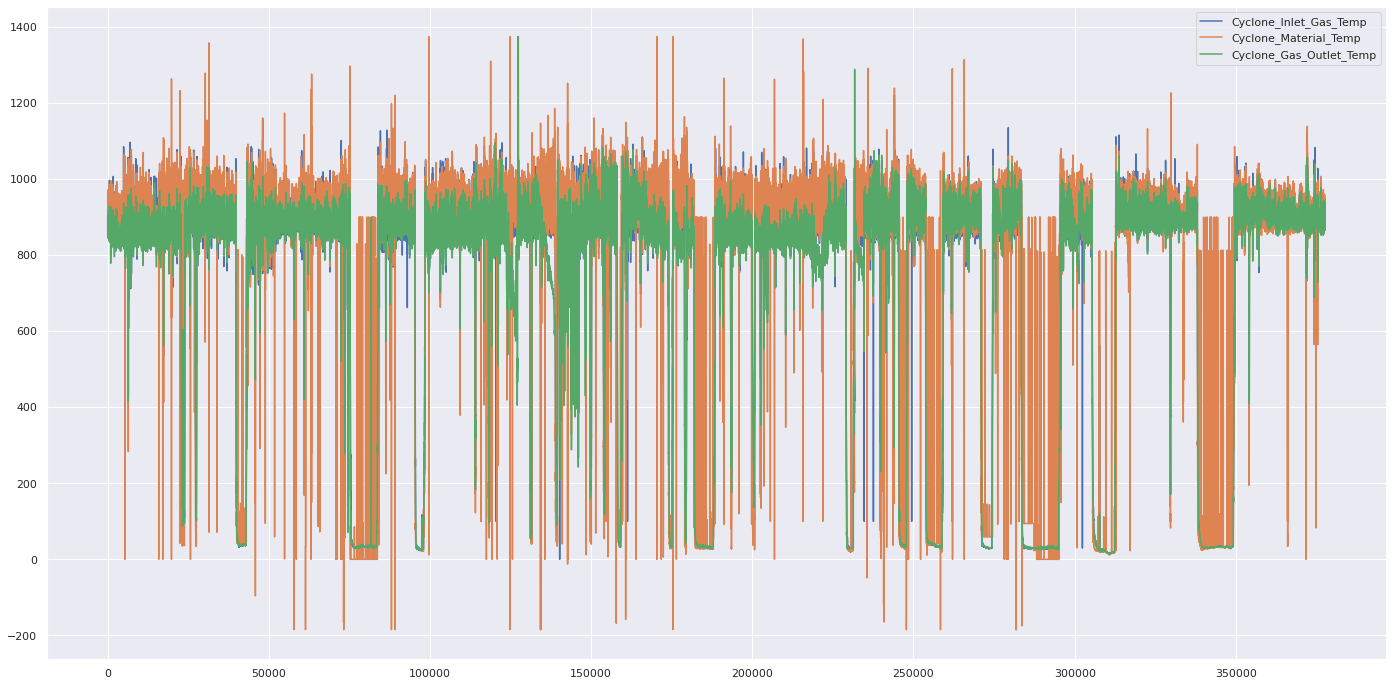

In [12]:
temp[['Cyclone_Inlet_Gas_Temp','Cyclone_Material_Temp','Cyclone_Gas_Outlet_Temp']].plot(figsize=(24,12))

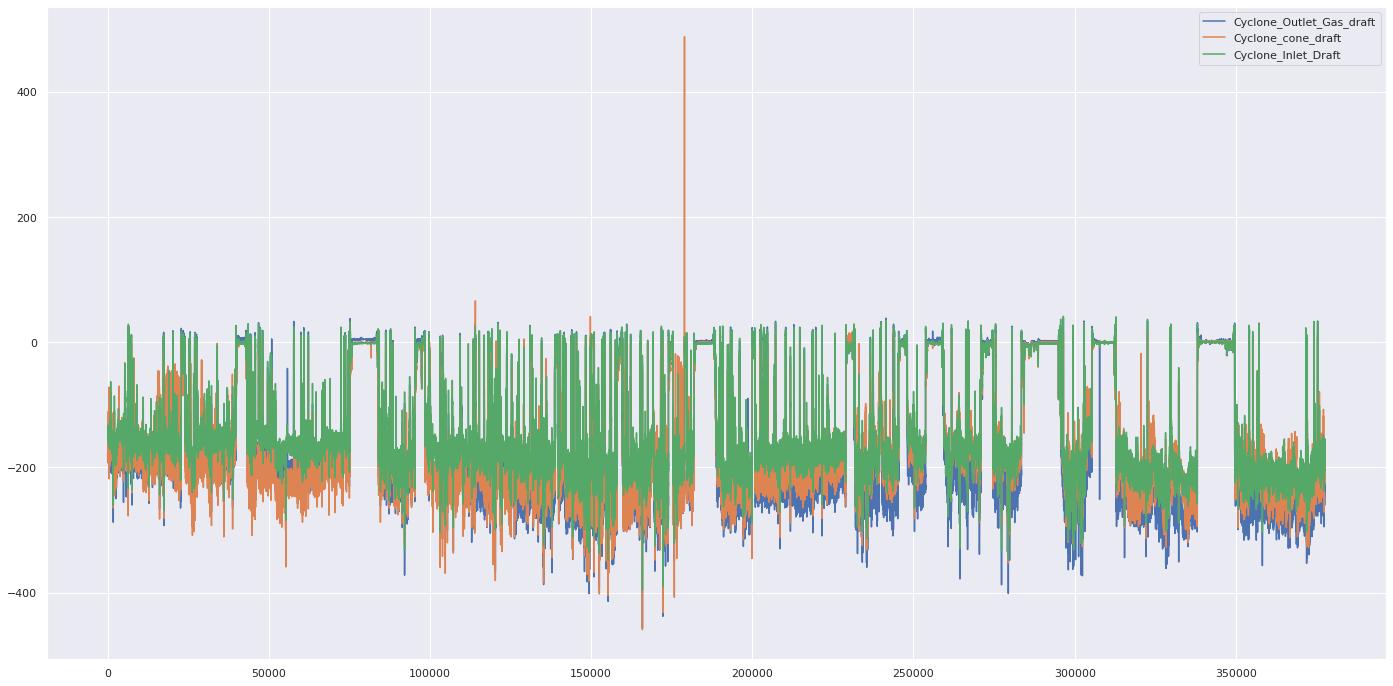

In [13]:
temp[['Cyclone_Outlet_Gas_draft','Cyclone_cone_draft','Cyclone_Inlet_Draft']].plot(figsize=(24,12))

#Pre-Processing the Data

In [14]:
X_train,X_test=tts(temp,test_size=0.20)

In [15]:
X_train_time=X_train[['time']]
X_train.drop(columns='time',inplace=True)
X_train.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,300899.000000,300899.000000,300899.000000,300899.000000,300899.000000,300899.000000
mean,727.277462,750.866202,-177.753809,-164.494517,715.690459,-141.247060
std,328.714475,350.863737,99.129960,90.090976,325.400428,77.606473
min,0.000000,-185.000000,-456.660000,-459.310000,13.790000,-396.370000
25%,856.240000,867.580000,-247.140000,-226.720000,801.720000,-193.450000
50%,882.390000,913.370000,-215.150000,-198.450000,871.520000,-169.400000
75%,901.050000,943.665000,-169.990000,-143.480000,899.310000,-136.140000
max,1135.630000,1375.000000,40.270000,488.860000,1375.000000,41.640000


In [16]:
X_test_time=X_test[['time']]
X_test.drop(columns='time',inplace=True)
X_test_time.describe()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,time
count,75225
unique,75225
top,3/30/2020 21:55
freq,1


Scaling the Data

In [17]:
scaler=preprocessing.MinMaxScaler()
X_train=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

In [18]:
X=pd.concat([X_train,X_test],ignore_index=True)
X.describe()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000
mean,0.640515,0.599890,0.561104,0.310838,0.515724,0.582316
std,0.289385,0.224950,0.199502,0.095021,0.238991,0.177186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.754013,0.674782,0.421528,0.245251,0.579080,0.463140
50%,0.776996,0.704077,0.485783,0.274993,0.630131,0.518048
75%,0.793498,0.723500,0.576560,0.332883,0.650532,0.593731
max,1.019373,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
X_time=pd.concat([X_train_time,X_test_time],ignore_index=True)
X_time.describe()

,time
count,376124
unique,376124
top,3/30/2020 21:55
freq,1


In [20]:
X=X_time.join(X)
X.describe()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000
mean,0.640515,0.599890,0.561104,0.310838,0.515724,0.582316
std,0.289385,0.224950,0.199502,0.095021,0.238991,0.177186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.754013,0.674782,0.421528,0.245251,0.579080,0.463140
50%,0.776996,0.704077,0.485783,0.274993,0.630131,0.518048
75%,0.793498,0.723500,0.576560,0.332883,0.650532,0.593731
max,1.019373,1.000000,1.000000,1.000000,1.000000,1.000000


# Anamoly Detection using PCA Model

##PCA creation


In [21]:
pca=PCA(n_components=4,svd_solver='full')

X_train_PCA=pd.DataFrame(pca.fit_transform(X_train))
X_test_PCA=pd.DataFrame(pca.transform(X_test))
X_train_PCA.describe()

,0,1,2,3
count,3.008990e+05,3.008990e+05,3.008990e+05,3.008990e+05
mean,-7.569946e-18,-1.135589e-16,-1.677831e-17,-5.725811e-17
std,5.073615e-01,1.020919e-01,5.172885e-02,2.467576e-02
min,-8.104898e-01,-5.203593e-01,-5.450684e-01,-4.432546e-01
25%,-2.939835e-01,-5.896996e-02,-9.337965e-03,-7.196470e-03
50%,-2.354767e-01,-2.175624e-02,-3.566330e-04,2.243655e-03
75%,-1.540864e-01,5.024770e-02,9.782668e-03,1.108149e-02
max,1.109237e+00,6.649435e-01,6.228455e-01,5.163032e-01


In [22]:
X_test_PCA.describe()

,0,1,2,3
count,75225.000000,75225.000000,75225.000000,75225.000000
mean,-0.001015,-0.000735,0.000389,-0.000071
std,0.507202,0.101658,0.052118,0.024565
min,-0.630213,-0.401617,-0.480345,-0.330553
25%,-0.294582,-0.059016,-0.009213,-0.007430
50%,-0.236339,-0.022203,-0.000288,0.002224
75%,-0.155612,0.048725,0.009812,0.010887
max,1.068390,0.609749,0.652274,0.530841


##Defining Various Functions for the Use in PCA Model

Defining Covariance matrix function

In [23]:
def cov_matrix(data,verbose=False):
  covariance=np.cov(data,rowvar=False)
  if is_pos_def(covariance):
    inv_covariance=np.linalg.inv(covariance)
    if is_pos_def(inv_covariance):
      return covariance,inv_covariance
    else:
      print('Error:Inverese covariance is not positive Definite')
  else:
    print('Error:covariance is not positive Definite')

Defining Mahalanobis distance


In [24]:
def MahalanobisDist(inv_covariance,mean_dist,data,verbose=False):
  diff=data-mean_dist
  md=[]
  for i in range(len(diff)):
    md.append(np.sqrt(diff[i].dot(inv_covariance).dot(diff[i])))
  return md

Defining Function for detecting outliers

Defining function for threshold

In [25]:
def calculate_threshold(dist,verbose=False):
  k=6.5
  threshold=np.mean(dist)*k
  return threshold

defining function to check positive definite of matrix

In [26]:
def is_pos_def(A):
  if np.allclose(A,A.T):
    try:
      np.linalg.cholesky(A)
      return True
    except np.linalg.LinAlgError:
      return False
  else:
    return False

##Creating Up PCA Model and detecting Anomaly

In [27]:
train_data=np.array(X_train_PCA.values)
test_data=np.array(X_test_PCA.values)

covariance,inv_covariance=cov_matrix(train_data)

mean_dist=train_data.mean(axis=0)

dist_test = MahalanobisDist(inv_covariance, mean_dist,test_data, verbose=False)
dist_train = MahalanobisDist(inv_covariance, mean_dist,train_data, verbose=False)
threshold = calculate_threshold(dist_train)

In [28]:
threshold

10.400732872739844

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 23.0)

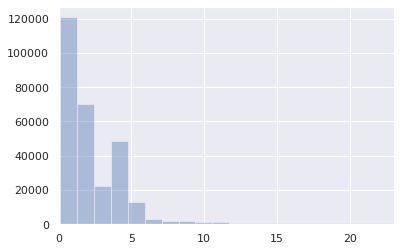

In [29]:
plt.figure()
sns.distplot(np.square(dist_train),bins=400,kde=False);
plt.xlim([0.0,23])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Mahalanobis dist')

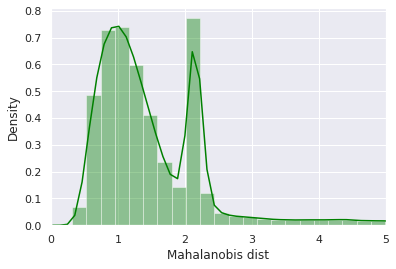

In [30]:
plt.figure()
sns.distplot(dist_train,
             bins = 100, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

## Detecting the Anomaly using Threshold Value

In [31]:
anomaly_train = pd.DataFrame()
anomaly_train['time']=np.array(X_train_time['time'])
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['time']=np.array(X_test_time['time'])
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.describe()

,Mob dist,Thresh
count,75225.000000,7.522500e+04
mean,1.596130,1.040073e+01
std,1.203951,5.151469e-12
min,0.301473,1.040073e+01
25%,0.916743,1.040073e+01
50%,1.267543,1.040073e+01
75%,2.102494,1.040073e+01
max,22.512519,1.040073e+01


In [32]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])

In [33]:
anomaly_alldata.describe()

,Mob dist,Thresh
count,376124.000000,3.761240e+05
mean,1.599316,1.040073e+01
std,1.200668,7.899825e-11
min,0.301473,1.040073e+01
25%,0.919879,1.040073e+01
50%,1.270715,1.040073e+01
75%,2.102753,1.040073e+01
max,22.512519,1.040073e+01


In [34]:
anomaly_alldata['Anomaly'].value_counts()

False    375780
True        344
Name: Anomaly, dtype: int64

##Visualising the Mahalanobis distance to better constraint Threshold value Manually for better result

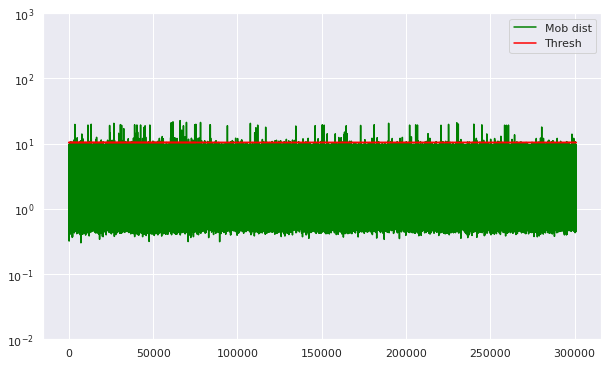

In [35]:
mpl.rcParams['agg.path.chunksize'] = 10000
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-2,1e3], color = ['green','red'])

not_anamoly=[]
true_anamoly=np.empty(shape=anomaly['Anomaly'])
for i,row in anomaly.iterrows():
  if row['Anomaly']==False:
    np.insert(not_anamoly,row['Mob dist'])
  else:
    np.insert(true_anamoly,row['Mob dist'])
marker_size=15
plt.scatter(not_anamoly,anamoly, marker_size, c={'green','red'})
plt.title("Point observations")
plt.xlabel("not_anamoly")
plt.ylabel("anamoly")
plt.show()

After seeing the mahalnobis distance vs threshold graph we will keep on stricting the value of threshold till we get desired result

##Preparing data for visualisation of result obtained

In [36]:
Anomaly=pd.DataFrame(anomaly_alldata[['time','Anomaly']],columns={'time','Anomaly'})

In [37]:
X_pca=X.merge(Anomaly,on='time')


In [38]:
X_pca.sample(frac=1)
X_pca.describe()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000
mean,0.640515,0.599890,0.561104,0.310838,0.515724,0.582316
std,0.289385,0.224950,0.199502,0.095021,0.238991,0.177186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.754013,0.674782,0.421528,0.245251,0.579080,0.463140
50%,0.776996,0.704077,0.485783,0.274993,0.630131,0.518048
75%,0.793498,0.723500,0.576560,0.332883,0.650532,0.593731
max,1.019373,1.000000,1.000000,1.000000,1.000000,1.000000


In [101]:
X_pca['time']=pd.to_datetime(X_pca['time'], format="%m/%d/%Y %H:%M")

In [102]:
X_pca_plot=pd.DataFrame()
k=0
for i,row in X_pca.iterrows():
    if k==344:
      break
    else:
      if row['Anomaly']==True:
        X_pca_plot=pd.concat([X_pca_plot,X_pca.iloc[i-100:i+100,:]])
        k+=1


In [103]:
X_pca_plot.describe()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,68800.000000,68800.000000,68800.000000,68800.000000,68800.000000,68800.000000
mean,0.640889,0.598980,0.560548,0.310526,0.515905,0.581897
std,0.289386,0.226036,0.199501,0.095022,0.238983,0.177226
min,0.000000,0.000000,0.138873,0.082865,0.000015,0.142257
25%,0.754055,0.674199,0.421367,0.244967,0.577582,0.462843
50%,0.777119,0.704090,0.484434,0.274613,0.630329,0.517351
75%,0.793877,0.723679,0.576540,0.332019,0.650710,0.594056
max,1.000000,0.968179,1.000000,0.522902,1.000000,0.997808


##Visualising Anamoly values with respect to values from actual Scaled Data_set

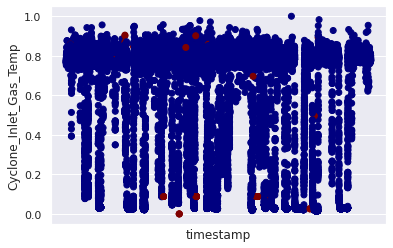

In [104]:
plt.scatter(X_pca_plot['time'],X_pca_plot['Cyclone_Inlet_Gas_Temp'],c=X_pca_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

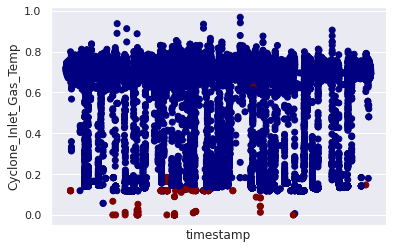

In [105]:
plt.scatter(X_pca_plot['time'],X_pca_plot['Cyclone_Material_Temp'],c=X_pca_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

[]

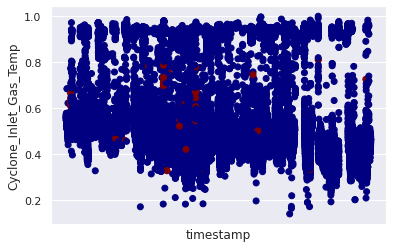

In [106]:
plt.scatter(X_pca_plot['time'],X_pca_plot['Cyclone_Outlet_Gas_draft'],c=X_pca_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()

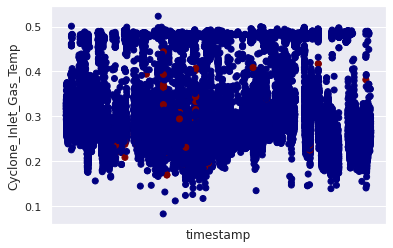

In [107]:
plt.scatter(X_pca_plot['time'],X_pca_plot['Cyclone_cone_draft'],c=X_pca_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

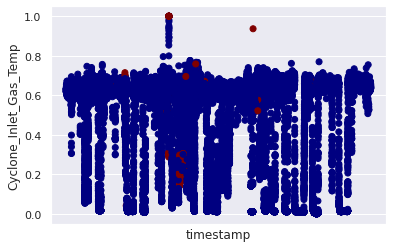

In [108]:
plt.scatter(X_pca_plot['time'],X_pca_plot['Cyclone_Gas_Outlet_Temp'],c=X_pca_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

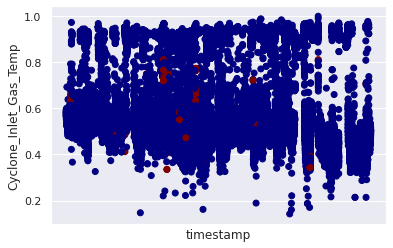

In [109]:
plt.scatter(X_pca_plot['time'],X_pca_plot['Cyclone_Inlet_Draft'],c=X_pca_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

#Anomaly Detection Using Autoencoder

##Creating Model and training it

In [48]:
seed(10)
tensorflow.compat.v1.set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(4,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [49]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)




Train on 285854 samples, validate on 15045 samples
Epoch 1/100
285854/285854 [==============================] - 36s 126us/step - loss: 8.8859e-04 - val_loss: 1.0126e-04
Epoch 2/100
285854/285854 [==============================] - 35s 124us/step - loss: 1.0127e-04 - val_loss: 9.5490e-05
Epoch 3/100
285854/285854 [==============================] - 35s 124us/step - loss: 8.2451e-05 - val_loss: 7.7091e-05
Epoch 4/100
285854/285854 [==============================] - 37s 128us/step - loss: 7.2986e-05 - val_loss: 7.2242e-05
Epoch 5/100
285854/285854 [==============================] - 36s 125us/step - loss: 6.9888e-05 - val_loss: 6.7604e-05
Epoch 6/100
285854/285854 [==============================] - 35s 124us/step - loss: 6.8531e-05 - val_loss: 6.5624e-05
Epoch 7/100
285854/285854 [==============================] - 35s 123us/step - loss: 6.7637e-05 - val_loss: 6.6423e-05
Epoch 8/100
285854/285854 [==============================] - 35s 123us/step - loss: 6.7034e-05 - val_loss: 6.9350e-05
Epoc

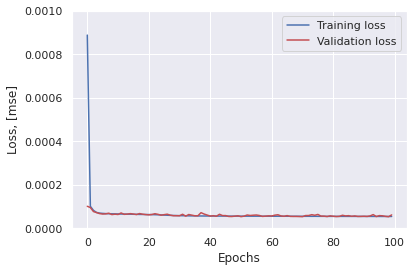

In [50]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.001])
plt.show()

##Predicting on Test_Data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.3)

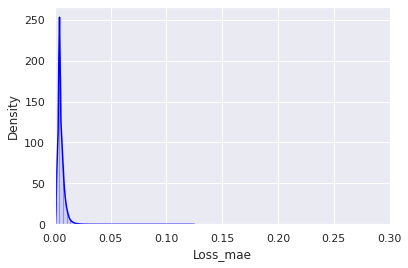

In [51]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 100, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.3])

In [89]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['time']=np.array(X_test_time['time'])
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.03
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']


In [90]:
scored.describe()

,Loss_mae,Threshold
count,75225.000000,7.522500e+04
mean,0.005531,3.000000e-02
std,0.003061,3.032317e-15
min,0.000831,3.000000e-02
25%,0.003843,3.000000e-02
50%,0.004794,3.000000e-02
75%,0.006683,3.000000e-02
max,0.124258,3.000000e-02


In [91]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['time']=np.array(X_train_time['time'])
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.03
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [92]:
scored.describe()

,Loss_mae,Threshold
count,376124.000000,3.761240e+05
mean,0.005544,3.000000e-02
std,0.003056,1.189918e-13
min,0.000648,3.000000e-02
25%,0.003843,3.000000e-02
50%,0.004795,3.000000e-02
75%,0.006697,3.000000e-02
max,0.124258,3.000000e-02


In [93]:
scored['Anomaly'].value_counts()

False    375887
True        237
Name: Anomaly, dtype: int64

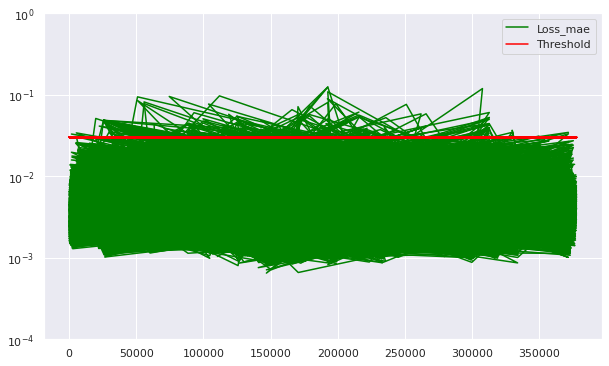

In [94]:
mpl.rcParams['agg.path.chunksize'] = 10000
scored.plot(logy=True, figsize = (10,6), ylim = [1e-4,1e0], color = ['green','red'])

Visualising the plot and constraining the threshold value for better *result*

##Preparing Data for visualisation Purpose of result

In [95]:
Anomaly_auto=pd.DataFrame(scored[['time','Anomaly']],columns={'time','Anomaly'})

In [96]:
X_auto=X.merge(Anomaly_auto,on='time')
X_auto.describe()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000,376124.000000
mean,0.640515,0.599890,0.561104,0.310838,0.515724,0.582316
std,0.289385,0.224950,0.199502,0.095021,0.238991,0.177186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.754013,0.674782,0.421528,0.245251,0.579080,0.463140
50%,0.776996,0.704077,0.485783,0.274993,0.630131,0.518048
75%,0.793498,0.723500,0.576560,0.332883,0.650532,0.593731
max,1.019373,1.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
X_auto['time']=pd.to_datetime(X_auto['time'], format="%m/%d/%Y %H:%M")
X_auto.sample(frac=1)

,time,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft,Anomaly
195778,2019-11-24 09:40:00,0.776027,0.718660,0.570201,0.365198,0.647402,0.607246,False
284558,2017-05-25 08:05:00,0.030318,0.146244,0.928340,0.483394,0.015993,0.901189,False
340884,2018-08-15 15:30:00,0.832754,0.777853,0.392953,0.218885,0.654102,0.424283,False
12874,2018-06-26 10:25:00,0.770533,0.714436,0.342402,0.197813,0.651582,0.419945,False
113516,2017-11-19 05:55:00,0.795567,0.752872,0.382207,0.258139,0.682848,0.425607,False
...,...,...,...,...,...,...,...,...
361069,2017-02-14 22:15:00,0.788796,0.718333,0.526291,0.277102,0.619794,0.531449,False
206295,2017-03-10 07:45:00,0.773218,0.718795,0.531846,0.273137,0.614857,0.540102,False
364601,2020-01-31 13:15:00,0.797117,0.715782,0.386131,0.298744,0.644478,0.399032,False
76329,2020-03-28 10:40:00,0.027289,0.134429,0.920210,0.485282,0.012871,0.906463,False


In [100]:
X_auto_plot=pd.DataFrame()
k=0
for i,row in X_auto.iterrows():
    if k==237:
      break
    else:
      if row['Anomaly']==True:
        X_auto_plot=pd.concat([X_auto_plot,X_auto.iloc[i-100:i+100,:]])
        k+=1


In [99]:
X_auto_plot.describe()

,Cyclone_Inlet_Gas_Temp,Cyclone_Material_Temp,Cyclone_Outlet_Gas_draft,Cyclone_cone_draft,Cyclone_Gas_Outlet_Temp,Cyclone_Inlet_Draft
count,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000,37400.000000
mean,0.640229,0.599692,0.562450,0.311621,0.515347,0.583400
std,0.289656,0.225257,0.200303,0.095384,0.239119,0.178165
min,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000
25%,0.753564,0.673910,0.422061,0.245660,0.577486,0.462980
50%,0.776952,0.704038,0.486839,0.275510,0.629712,0.518687
75%,0.793350,0.723604,0.580142,0.337078,0.650355,0.597498
max,1.000000,1.000000,0.981849,1.000000,1.000000,0.974475


##Visualising Anamoly values with respect to values from actual Scaled Data_set

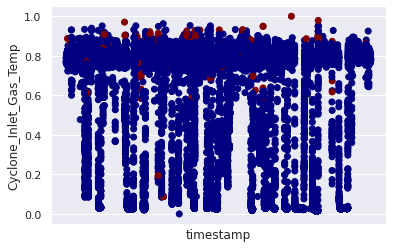

In [110]:
plt.scatter(X_auto_plot['time'],X_auto_plot['Cyclone_Inlet_Gas_Temp'],c=X_auto_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

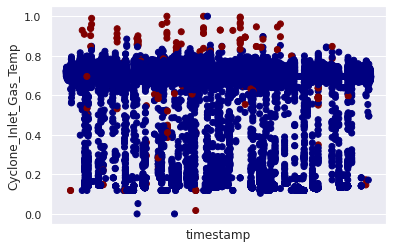

In [111]:
plt.scatter(X_auto_plot['time'],X_auto_plot['Cyclone_Material_Temp'],c=X_auto_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

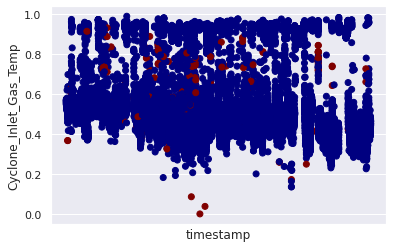

In [112]:
plt.scatter(X_auto_plot['time'],X_auto_plot['Cyclone_Outlet_Gas_draft'],c=X_auto_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

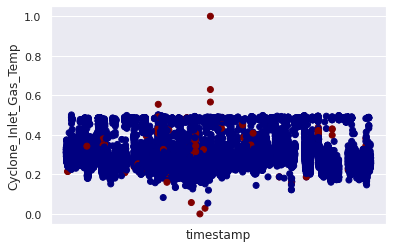

In [113]:
plt.scatter(X_auto_plot['time'],X_auto_plot['Cyclone_cone_draft'],c=X_auto_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

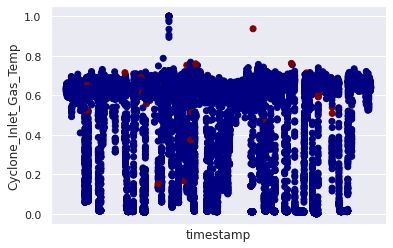

In [114]:
plt.scatter(X_auto_plot['time'],X_auto_plot['Cyclone_Gas_Outlet_Temp'],c=X_auto_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

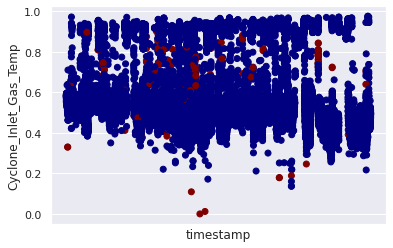

In [115]:
plt.scatter(X_auto_plot['time'],X_auto_plot['Cyclone_Inlet_Draft'],c=X_auto_plot['Anomaly'],cmap='jet')
plt.xticks([])
plt.ylabel('Cyclone_Inlet_Gas_Temp')
plt.xlabel('timestamp')
plt.plot()
plt.show()

#Creating Separate result table for both the Models for better comaprison

In [116]:
result_PCA=result
result_auto=result
for i,row in scored.iterrows():
  if row['Anomaly']==True:
    result_auto= result_auto.append({'Abnormality_Time' : row['time']},  
                ignore_index = True)
for i,row in anomaly_alldata.iterrows():
  if row['Anomaly']==True:
    result_PCA= result_PCA.append({'Abnormality_Time' : row['time']},  
                ignore_index = True)


In [117]:
result_PCA.describe()

,Abnormality_Time
count,727
unique,727
top,2/13/2018 21:45
freq,1


In [118]:
result_auto.describe()

,Abnormality_Time
count,620
unique,620
top,5/24/2017 15:00
freq,1


In [136]:
result_auto

,Abnormality_Time
0,1/16/2017 20:45
1,1/26/2017 8:35
2,3/1/2017 15:50
3,3/14/2017 21:45
4,3/25/2017 1:50
...,...
615,2/24/2018 9:30
616,1/22/2019 5:20
617,7/13/2018 23:45
618,11/6/2017 13:05


In [137]:
result_PCA

,Abnormality_Time
0,1/16/2017 20:45
1,1/26/2017 8:35
2,3/1/2017 15:50
3,3/14/2017 21:45
4,3/25/2017 1:50
...,...
722,5/4/2018 15:50
723,11/19/2019 0:25
724,7/13/2018 23:45
725,8/2/2017 2:00
